## Imports

In [1]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping

import torch
import torch.nn as nn

import numpy as np

import os

from TurbulenceNetwork import TurbulenceNetwork
from TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2


## Misc Utilities

In [2]:
class MAPELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MAPELoss, self).__init__()
        self.eta = 1e-3

    def forward(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true) + self.eta)

        return torch.mean(l)

class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l


## Data Generation

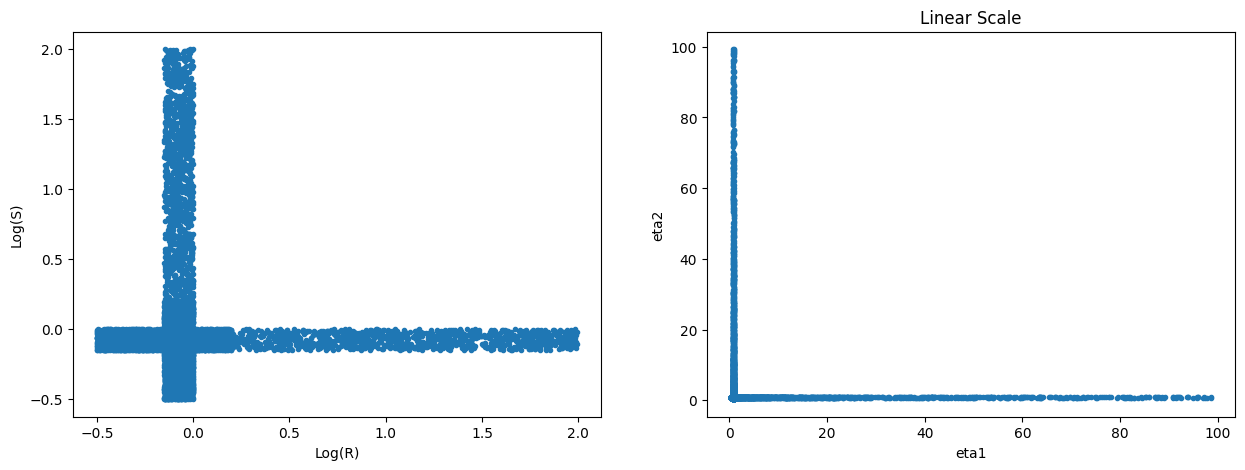

In [14]:
# Data generators for the different turbulence closures
LLR_gen = TurbulenceClosureDataGenerator('LRR')
SSG_gen = TurbulenceClosureDataGenerator('SSG')
SZL_gen = TurbulenceClosureDataGenerator('SZL')

# Defining the ranges for the different scales
log_narrow = (-.5, .2)
log = (-.5, 2)
lin = (.1, 10_000)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = True
drop_eta_1 = False
drop_eta_2 = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.15, 0.0]))**2
eta_2_range = (10**np.array([-.15, 0.0]))**2

# Generating data on a narrowed log scale
LLR_x_log_narrow, LLR_y_log_narrow = LLR_gen((10**np.random.uniform(*log_narrow, 10))**2, (10**np.random.uniform(*log_narrow, 10))**2)
SSG_x_log_narrow, SSG_y_log_narrow = SSG_gen((10**np.random.uniform(*log_narrow, 20_000))**2, (10**np.random.uniform(*log_narrow, 20_000))**2)
SZL_x_log_narrow, SZL_y_log_narrow = SZL_gen((10**np.random.uniform(*log_narrow, 10))**2, (10**np.random.uniform(*log_narrow, 10))**2)

# Generating data on a log scale
LLR_x_log, LLR_y_log = LLR_gen((10**np.random.uniform(*log, 10))**2, (10**np.random.uniform(*log, 10))**2)
SSG_x_log, SSG_y_log = SSG_gen((10**np.random.uniform(*log, 24_000))**2, (10**np.random.uniform(*log, 24_000))**2)
SZL_x_log, SZL_y_log = SZL_gen((10**np.random.uniform(*log, 10))**2, (10**np.random.uniform(*log, 10))**2)

# Generating data on a linear scale
LLR_x_lin, LLR_y_lin = LLR_gen(np.random.uniform(*lin, 10), np.random.uniform(*lin, 10))
SSG_x_lin, SSG_y_lin = SSG_gen(np.random.uniform(*lin, 10_000), np.random.uniform(*lin, 10_000))
SZL_x_lin, SZL_y_lin = SZL_gen(np.random.uniform(*lin, 10), np.random.uniform(*lin, 10))

x = np.concatenate((
    LLR_x_log_narrow, SSG_x_log_narrow, SZL_x_log_narrow,
    LLR_x_log, SSG_x_log, SZL_x_log,
    SSG_x_lin, LLR_x_lin, SZL_x_lin
    ))

y = np.concatenate((
    LLR_y_log_narrow, SSG_y_log_narrow, SZL_y_log_narrow,
    LLR_y_log, SSG_y_log, SZL_y_log,
    SSG_y_lin, LLR_y_lin, SZL_y_lin
    ))

if drop_eta_1:
    x[:, 0] = 0

if drop_eta_2:
    x[:, 1] = 0

if exclude_area:
    eta_1_points = (x[:, 0] < eta_1_range[0]) | (x[:, 0] > eta_1_range[1])
    eta_2_points = (x[:, 1] < eta_2_range[0]) | (x[:, 1] > eta_2_range[1])

    kept_points = eta_1_points & eta_2_points

    x = x[kept_points]
    y = y[kept_points]

if include_area:
    eta_1_points = (x[:, 0] > eta_1_range[0]) & (x[:, 0] < eta_1_range[1])
    eta_2_points = (x[:, 1] > eta_2_range[0]) & (x[:, 1] < eta_2_range[1])

    kept_points = eta_1_points | eta_2_points

    x = x[kept_points]
    y = y[kept_points]


if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(np.log10(np.sqrt(x)))

total = np.concatenate((x, y), axis=1)

np.random.shuffle(total)

etas_train = total[:, :2]
gs_train = total[:, 2:]


x_test_LLR , y_test_LLR = LLR_gen((10**np.random.uniform(*log, 10))**2, (10**np.random.uniform(*log, 10))**2)
x_test_SSG , y_test_SSG = SSG_gen((10**np.random.uniform(*log, 30_000))**2, (10**np.random.uniform(*log, 30_000))**2)
x_test_SZL , y_test_SZL = SZL_gen((10**np.random.uniform(*log, 10))**2, (10**np.random.uniform(*log, 10))**2)

etas_test = np.concatenate((x_test_LLR, x_test_SSG, x_test_SZL))
gs_test = np.concatenate((y_test_LLR, y_test_SSG, y_test_SZL))


## Network Training

In [15]:
model = TurbulenceNetwork(input_dim=2, output_dim=3, num_layers=8, nodes=[100]*8, dropout=0.1)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam


In [16]:
callbacks = [EarlyStopping(patience=10, threshold=0.0001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
            Checkpoint(monitor='valid_loss_best', f_params='TurbulenceNetwork.pt', dirname='./Model_Checkpoints/')
]

net = NeuralNetRegressor(   
        module=model,
        criterion=criterion,
        optimizer=optimizer,
        optimizer__weight_decay=0.00001,
        lr=0.0001,
        batch_size=64,
        max_epochs=400,
        device=device,
        iterator_train__shuffle=True,
        iterator_train__num_workers=4,
        iterator_train__pin_memory=True,
        iterator_valid__shuffle=False,
        iterator_valid__num_workers=4,
        iterator_valid__pin_memory=True,
        callbacks=callbacks,
)

net = net.fit(etas_train, gs_train)



  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.1905        0.1035     +  0.4168
      2        0.0980        0.0522     +  0.4059
      3        0.0631        0.0378     +  0.4047
      4        0.0510        0.0236     +  0.4054
      5        0.0415        0.0210     +  0.3916
      6        0.0366        0.0184     +  0.3972
      7        0.0343        0.0176     +  0.3836
      8        0.0315        0.0162     +  0.3914
      9        0.0293        0.0145     +  0.3962
     10        0.0278        0.0133     +  0.3792
     11        0.0262        0.0131     +  0.3840
     12        0.0256        0.0121     +  0.4016
     13        0.0244        0.0114     +  0.3957
     14        0.0232        0.0114        0.3834
     15        0.0225        0.0113     +  0.3814
     16        0.0220        0.0106     +  0.4059
     17        0.0211        0.0108        0.4046
     18        0.0206        0.0109        0.3872


In [17]:
loss = RMSELoss()

y_pred = net.predict(etas_test)
y_true = gs_test

print(loss(torch.tensor(y_pred), torch.tensor(y_true)))

tensor(0.0110, dtype=torch.float64)


## Reinitializing Trained Model

In [18]:
checkpoint_dir = './Model_Checkpoints'

net = NeuralNetRegressor(
    module=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

net.initialize()
net.load_params(f_params=os.path.join(checkpoint_dir,'TurbulenceNetwork.pt'),
                f_optimizer=os.path.join(checkpoint_dir, 'optimizer.pt'),
                f_criterion=os.path.join(checkpoint_dir, 'criterion.pt'),
                f_history=os.path.join(checkpoint_dir, 'history.json')
)

## Generating Statistics Data

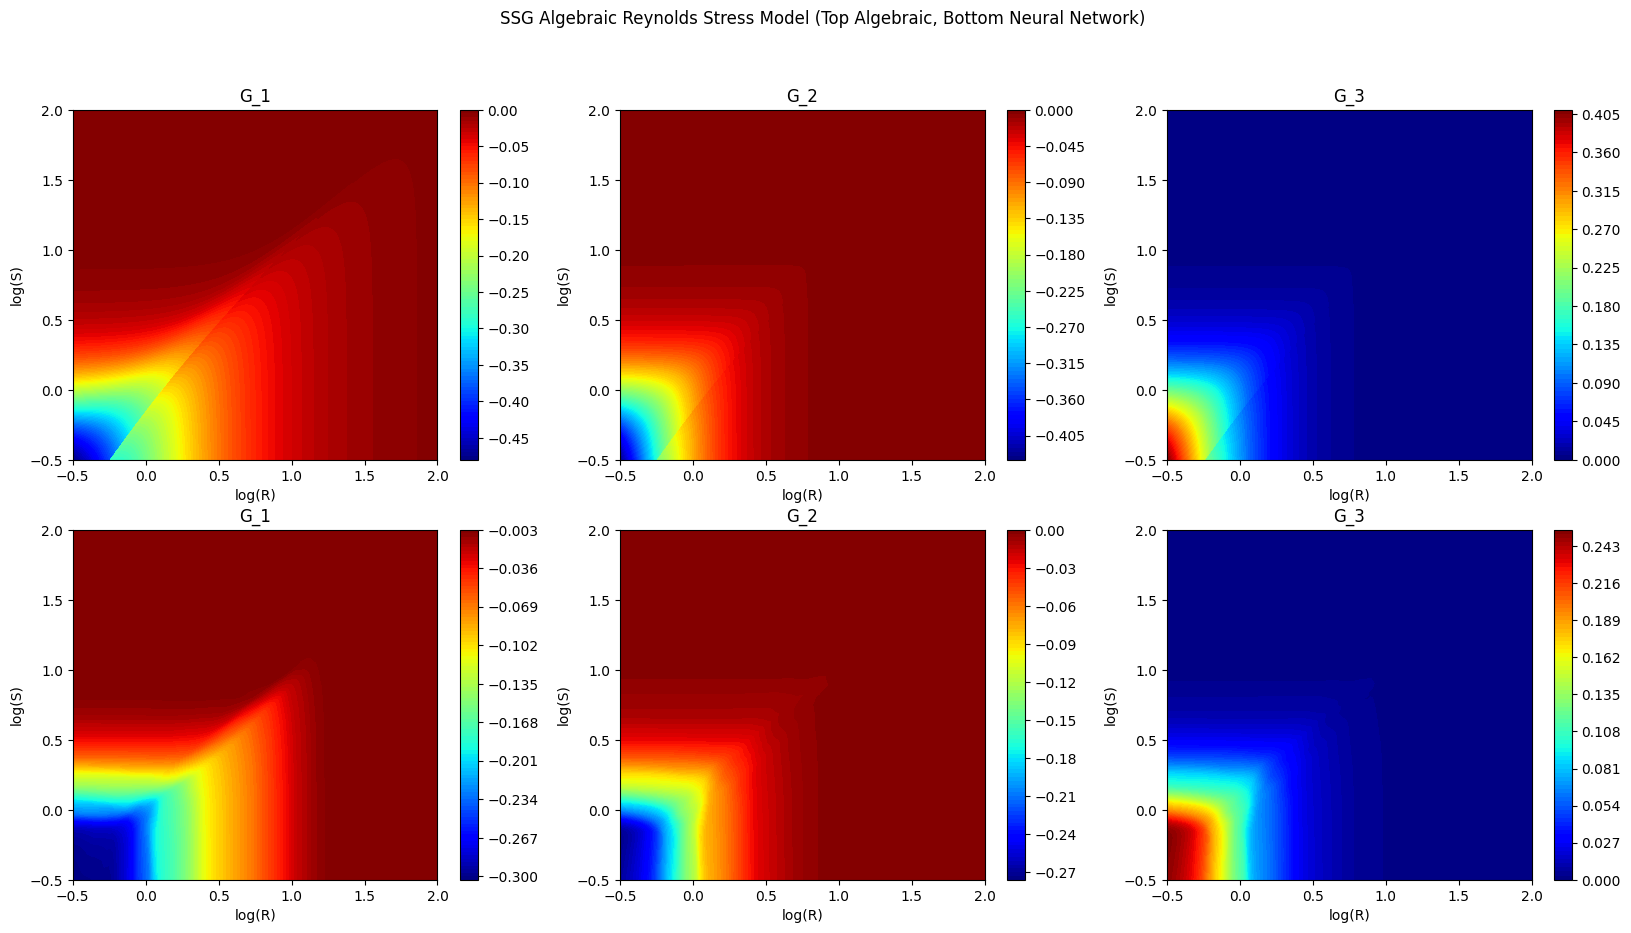

In [19]:
dim = 800
x_grid, y_grid = np.meshgrid(np.linspace(-.5, 2, dim),np.linspace(-.5, 2, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

pred = net.predict(etas)

pred = pred.T.reshape(3, dim, dim)

plot_heat_map_compare(x_grid, y_grid, target, pred)


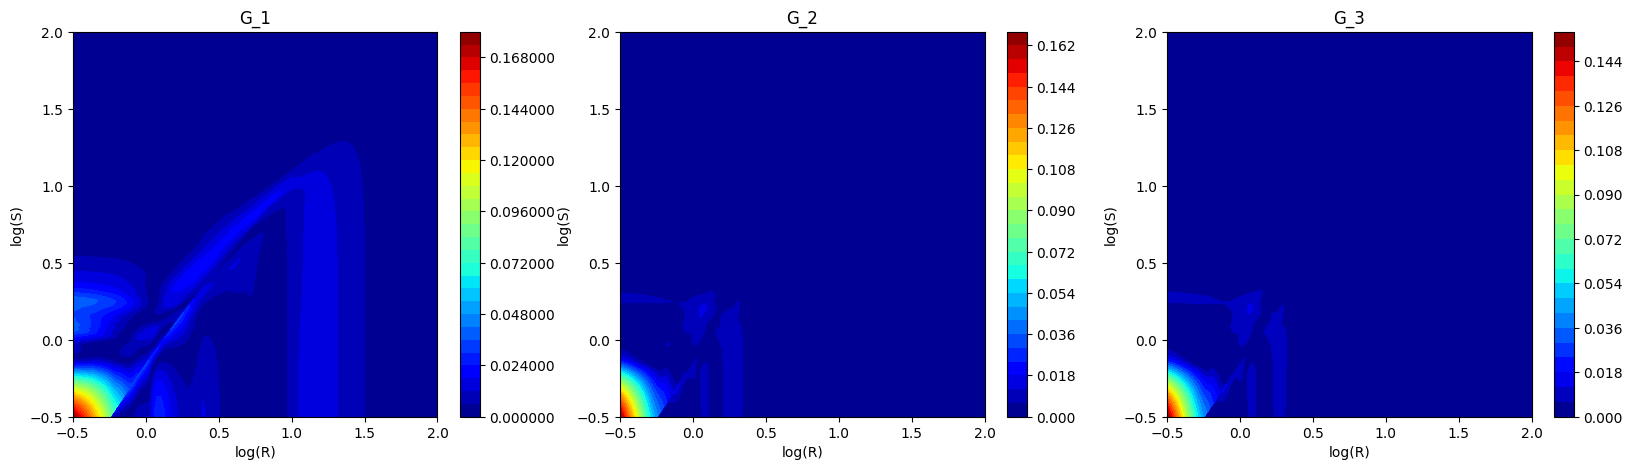

In [20]:
plot_heat_map_loss(x_grid, y_grid, target, pred, levels=30, base=6)
del pred

## Generating Model Uncertainty From Dropout

In [21]:
T = 300
predictions = np.zeros((T, dim*dim, 3))

batch_size = dim*dim // 2


net.module.dropout_on(.02)

for i in range(T):
    batches = np.zeros((len(etas)//batch_size, batch_size , 3))
    for j in range(len(etas)//batch_size):
        batches[j] = net.module(torch.tensor(etas[j*batch_size:(j+1)*batch_size]).to(device)).cpu().detach()
    print(i)
    predictions[i] = batches.reshape(dim*dim, 3)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

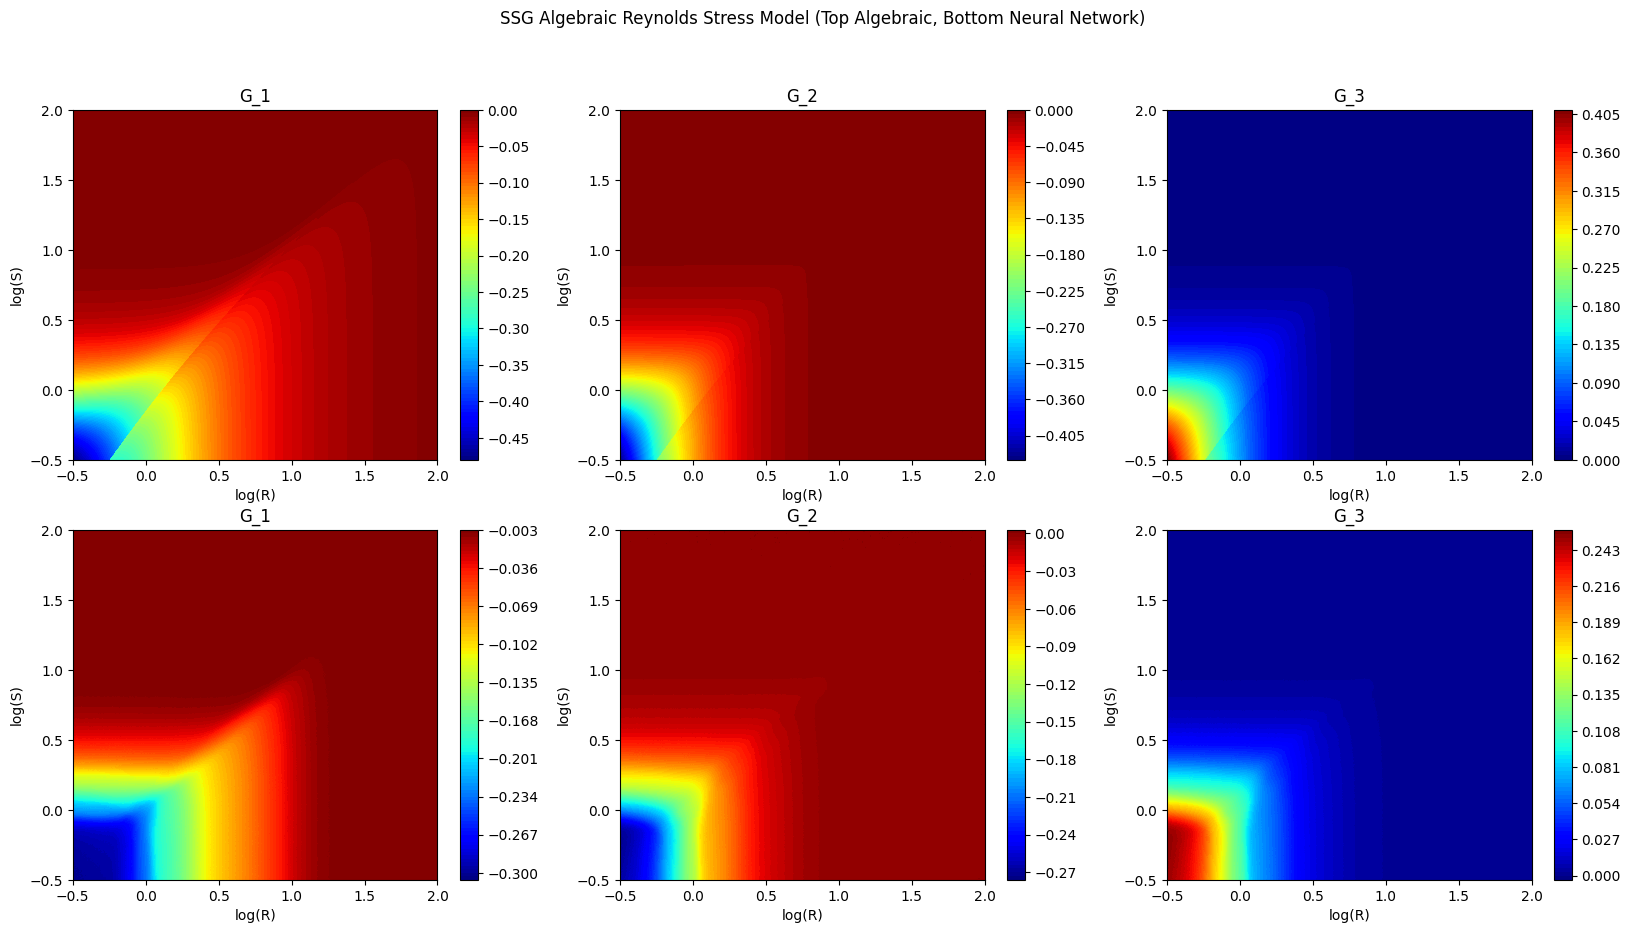

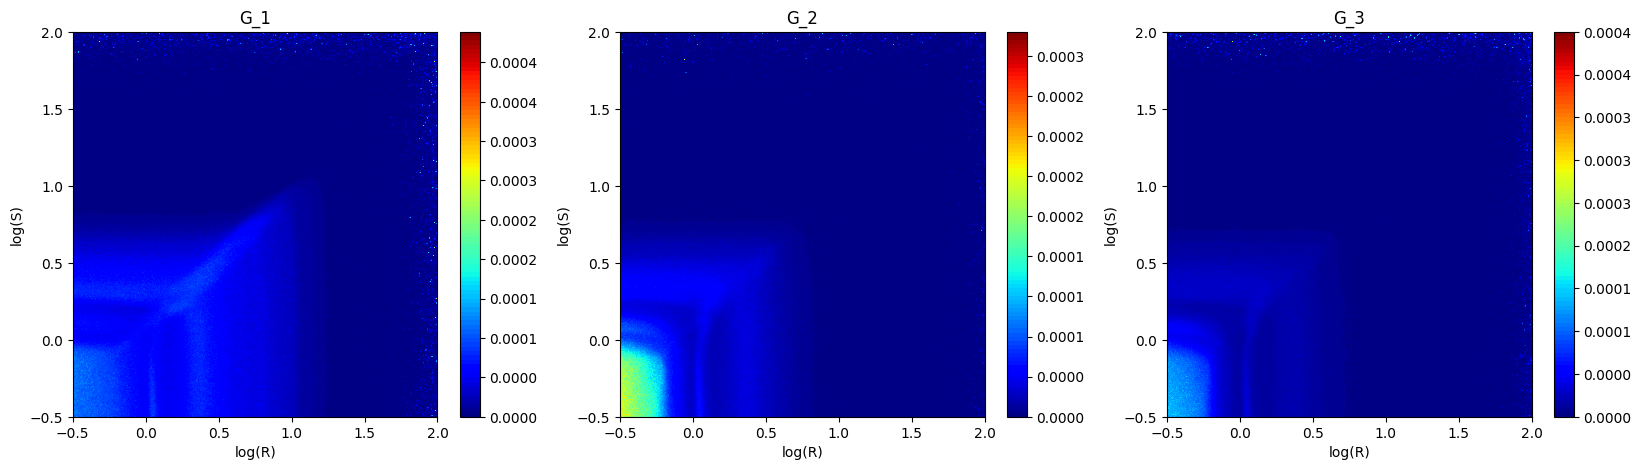

In [22]:
mean_pred = np.mean(predictions, axis=0)

variance_pred = np.mean((predictions - mean_pred)**2, axis=0)

del predictions

plot_heat_map_compare(x_grid, y_grid, target, mean_pred.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, variance_pred.T.reshape(3, dim, dim))
